In [1]:
## EDIT:
base_dir = '/glade/work/kjmayer/research/catalyst/TransferLearning/runmean_analysis/artificial_bias/perfectmodel_TLtest/E3SM_analysis/'
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import random
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import time

import sys
sys.path.append(base_dir+'functions/')
from utils import split_SDbias
from exp_hp import get_hp

2024-08-09 12:41:29.966803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-09 12:41:32.126392: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(x_data, top_pred_idx=top_pred_idx)     
        grads.append(grad)
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)
    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

In [3]:
EXP_NAME = 'exp2'
hps = get_hp(EXP_NAME)
print(hps['train_mems'],hps['val_mems'][0],hps['test_mems'][0])

_, _, X1test, _, _, Y1test, inew = split_SDbias(trainmems = hps['train_mems'],
                                                      valmem = hps['val_mems'][0],
                                                      testmem = hps['test_mems'][0],
                                                      months = [11,12,1,2], # months for X (Y+leadtime are accounted for in function)
                                                      lead = hps['LEAD']) 

['0101', '0111', '0121', '0131', '0141', '0151', '0161', '0171', '0181'] 0191 0301
files do not exist - loading data & saving


In [4]:
nlat = X1test.shape[1]
nlon = X1test.shape[2]
X1test = X1test.reshape((X1test.shape[0],nlat*nlon))
number_inputs = nlat*nlon

In [5]:
#----- SET UP & TRAIN NN -----
GLOBAL_SEED = hps['GLOBAL_SEED']
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.random.set_seed(GLOBAL_SEED)


for SEED in np.arange(0,10):
    IG_neg_heatmap = []
    IG_pos_heatmap = []
    print(SEED)
    annfi_name = 'ann_60Eshift_'+EXP_NAME+'_seed'+str(SEED)+'.h5'
    model = tf.keras.models.load_model(base_dir+'train/saved_models/'+annfi_name)
    
    pred = model.predict(X1test)
    predconf = np.max(pred,axis=-1)
    predval  = np.argmax(pred,axis=-1)

    iconf = np.where(predconf >= np.percentile(predconf,q=80))
    icorr = np.where(predval[iconf] == Y1test[iconf])
    
    ineg = np.where(Y1test[iconf][icorr] == 0)
    ipos = np.where(Y1test[iconf][icorr] == 1)
    
    # print(len(ineg[0]))
    # print(len(ipos[0]))
    
    if len(ineg[0]) > 0:
        for neg_sample in X1test[iconf][icorr][ineg]:
            IG_negsample_heatmap = get_integrated_gradients(neg_sample.reshape((1,number_inputs)),top_pred_idx=0).numpy()[0]
            IG_neg_heatmap.append(IG_negsample_heatmap/np.max(np.abs(IG_negsample_heatmap)))
        
        IG_neg_heatmap_reshape = np.asarray(IG_neg_heatmap).reshape((len(ineg[0]),nlat,nlon))
        np.save(base_dir+'IG/data/IG_ann1_60Eshift_'+EXP_NAME+'_negconf_seed'+str(SEED)+'.npy',
                IG_neg_heatmap_reshape,
                allow_pickle=True)
    
    if len(ipos[0]) > 0:
        for pos_sample in X1test[iconf][icorr][ipos]:
            IG_possample_heatmap = get_integrated_gradients(pos_sample.reshape((1,number_inputs)),top_pred_idx=1).numpy()[0]
            IG_pos_heatmap.append(IG_possample_heatmap/np.max(np.abs(IG_possample_heatmap)))
            
        IG_pos_heatmap_reshape = np.asarray(IG_pos_heatmap).reshape((len(ipos[0]),nlat,nlon))
        np.save(base_dir+'IG/data/IG_ann1_60Eshift_'+EXP_NAME+'_posconf_seed'+str(SEED)+'.npy',
                IG_pos_heatmap_reshape,
                allow_pickle=True)

0


2024-08-09 12:44:02.781504: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


235/235 [==============================] - 1s 1ms/step
1
235/235 [==============================] - 1s 2ms/step
2
235/235 [==============================] - 0s 1ms/step
3
235/235 [==============================] - 1s 2ms/step
4
235/235 [==============================] - 1s 2ms/step
5
235/235 [==============================] - 1s 2ms/step
6
235/235 [==============================] - 1s 2ms/step
7
235/235 [==============================] - 1s 2ms/step
8
235/235 [==============================] - 1s 2ms/step
9
235/235 [==============================] - 1s 3ms/step


In [6]:
IG_neg_heatmap_mean = np.mean(np.asarray(IG_neg_heatmap).reshape((len(ineg[0]),nlat,nlon)),0)
IG_pos_heatmap_mean = np.mean(np.asarray(IG_pos_heatmap).reshape((len(ipos[0]),nlat,nlon)),0)

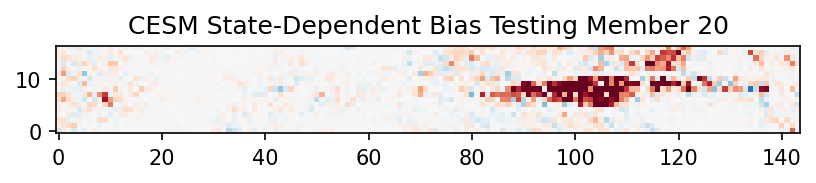

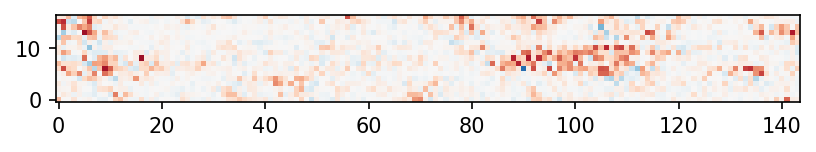

In [7]:
plt.imshow(IG_neg_heatmap_mean,origin='lower',cmap='RdBu_r',vmin=-.1,vmax=.1)
plt.title('State-Dependent Bias Testing Member 20')
plt.show()
plt.imshow(IG_pos_heatmap_mean,origin='lower',cmap='RdBu_r',vmin=-.1,vmax=.1)
plt.show()